# pygSQuiG Tutorial: Surface Quasi-Geostrophic Turbulence

This notebook demonstrates how to use pygSQuiG to simulate SQG turbulence. We'll cover:

1. Basic setup and initialization
2. Running a decaying turbulence simulation
3. Forced-dissipative turbulence
4. Analyzing results and computing diagnostics
5. Visualizing energy spectra and fields

## 1. Setup and Imports

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# pygSQuiG imports
from pygsquig.core.grid import ifft2, make_grid
from pygsquig.core.solver import gSQGSolver
from pygsquig.forcing.damping import CombinedDamping
from pygsquig.forcing.ring_forcing import RingForcing
from pygsquig.utils.diagnostics import (
    compute_energy_spectrum,
    compute_enstrophy,
    compute_total_energy,
)

# Set up plotting
plt.style.use('default')
%matplotlib inline

## 2. Grid and Solver Initialization

In [ ]:
# Grid parameters
N = 256          # Resolution (use powers of 2)
L = 2 * np.pi    # Domain size [0, L] × [0, L]

# Create grid
grid = make_grid(N, L)
print(f"Grid created: {N}×{N} points, domain size {L:.2f}×{L:.2f}")

# Physical parameters
alpha = 1.0      # SQG case (α=1)
nu_p = 1e-16     # Hyperviscosity coefficient (CORRECTED: was 1e-2, which causes NaN)
p = 8            # Hyperviscosity order

# Create solver
solver = gSQGSolver(grid, alpha=alpha, nu_p=nu_p, p=p)
print(f"\nSolver initialized:")
print(f"  α = {alpha} (SQG)")
print(f"  Hyperviscosity: ν_{p} = {nu_p:.1e}")

## 3. Decaying Turbulence Simulation

First, let's simulate freely decaying SQG turbulence starting from a random initial condition.

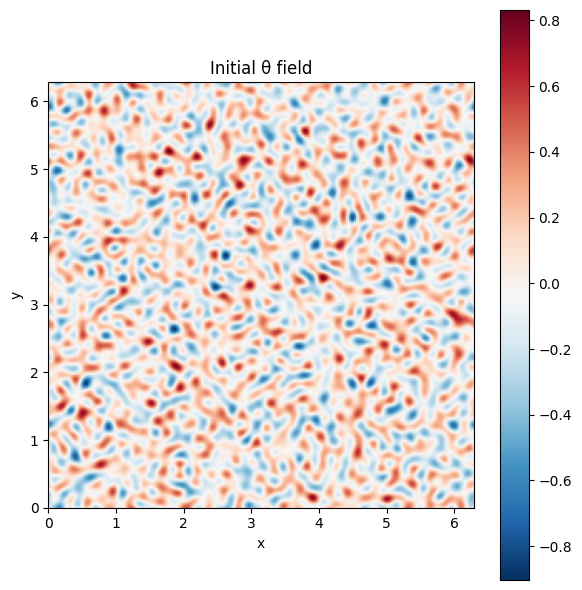

Initial energy: 97.048040


In [3]:
# Initialize with random field
state = solver.initialize(seed=42)

# Convert to physical space to visualize
theta_initial = ifft2(state['theta_hat']).real

# Plot initial condition
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
im = ax.imshow(theta_initial, cmap='RdBu_r', origin='lower', 
               extent=[0, L, 0, L])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Initial θ field')
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

print(f"Initial energy: {compute_total_energy(state['theta_hat'], grid, alpha):.6f}")

In [4]:
# Time stepping parameters
dt = 0.001
n_steps = 2000
output_interval = 200

# Storage for diagnostics
times = [0.0]
energies = [compute_total_energy(state['theta_hat'], grid, alpha)]
enstrophies = [compute_enstrophy(state['theta_hat'], grid, alpha)]

# Run simulation
print("Running decaying turbulence simulation...")
for step in range(n_steps):
    state = solver.step(state, dt)
    
    if (step + 1) % output_interval == 0:
        t = state['time']
        E = compute_total_energy(state['theta_hat'], grid, alpha)
        Z = compute_enstrophy(state['theta_hat'], grid, alpha)
        
        times.append(float(t))
        energies.append(float(E))
        enstrophies.append(float(Z))
        
        print(f"Step {step+1}: t={t:.3f}, E={E:.6f}, Z={Z:.3f}")

print("\nSimulation complete!")
print(f"Energy decay: {(1 - energies[-1]/energies[0])*100:.1f}%")

Running decaying turbulence simulation...
Step 200: t=0.200, E=nan, Z=nan
Step 400: t=0.400, E=nan, Z=nan
Step 600: t=0.600, E=nan, Z=nan
Step 800: t=0.800, E=nan, Z=nan
Step 1000: t=1.000, E=nan, Z=nan


KeyboardInterrupt: 

In [ ]:
# Plot energy and enstrophy evolution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Energy
ax1.plot(times, energies, 'b-', linewidth=2)
ax1.set_xlabel('Time')
ax1.set_ylabel('Energy')
ax1.set_title('Energy Decay')
ax1.grid(True, alpha=0.3)

# Enstrophy
ax2.plot(times, enstrophies, 'r-', linewidth=2)
ax2.set_xlabel('Time')
ax2.set_ylabel('Enstrophy')
ax2.set_title('Enstrophy Evolution')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Visualize final field and compute spectrum
theta_final = ifft2(state['theta_hat']).real
k_bins, E_k = compute_energy_spectrum(state['theta_hat'], grid, alpha)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Final field
im = ax1.imshow(theta_final, cmap='RdBu_r', origin='lower',
                extent=[0, L, 0, L])
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title(f'Final θ field (t={state["time"]:.1f})')
plt.colorbar(im, ax=ax1)

# Energy spectrum
ax2.loglog(k_bins, E_k, 'b-', linewidth=2, label='Simulation')

# Add reference slopes
k_ref = k_bins[k_bins > 10]
ax2.loglog(k_ref, 1e-3 * k_ref**(-5/3), 'k--', alpha=0.5, label='k⁻⁵/³')
ax2.loglog(k_ref, 1e-7 * k_ref**(-3), 'k:', alpha=0.5, label='k⁻³')

ax2.set_xlabel('Wavenumber k')
ax2.set_ylabel('Energy Spectrum E(k)')
ax2.set_title('Energy Spectrum')
ax2.grid(True, alpha=0.3, which='both')
ax2.legend()
ax2.set_xlim(1, N/2)

plt.tight_layout()
plt.show()

## 4. Forced-Dissipative Turbulence

Now let's simulate statistically stationary turbulence with forcing and damping.

In [ ]:
# Forcing parameters
kf = 30.0        # Forcing wavenumber
dk = 2.0         # Forcing bandwidth
epsilon = 0.1    # Target energy injection rate

# Create forcing and damping
forcing = RingForcing(kf=kf, dk=dk, epsilon=epsilon)
damping = CombinedDamping(mu=0.1, kf=kf, nu_p=1e-16, p=8)  # Match solver nu_p

print(f"Forcing configuration:")
print(f"  Ring forcing at kf = {kf:.0f} ± {dk:.0f}")
print(f"  Target injection rate ε = {epsilon}")
print(f"\nDamping configuration:")
print(f"  Large-scale damping μ = {damping.mu}")
print(f"  Hyperviscosity ν₈ = {damping.nu_p:.1e}")

In [ ]:
# Start from low energy state
state_forced = solver.initialize(seed=123)
rng_key = jax.random.PRNGKey(456)

# Parameters
dt = 0.001
n_spinup = 2000   # Reduced for faster testing
n_stats = 1000    # Reduced for faster testing

# Spin up to statistically steady state
print("Spinning up to steady state...")
for step in range(n_spinup):
    rng_key, subkey = jax.random.split(rng_key)
    
    # Apply forcing
    forcing_hat = forcing(state_forced['theta_hat'], subkey, dt, grid)
    
    # Apply damping
    damping_hat = damping(state_forced['theta_hat'], grid)
    
    # Combined forcing term
    def combined_forcing(theta_hat, **kwargs):
        return forcing_hat + damping_hat
    
    state_forced = solver.step(state_forced, dt, forcing=combined_forcing)
    
    if (step + 1) % 500 == 0:
        E = compute_total_energy(state_forced['theta_hat'], grid, alpha)
        print(f"  Step {step+1}: E = {E:.4f}")

print("\nCollecting statistics...")
spectra = []
injection_rates = []

for step in range(n_stats):
    rng_key, subkey = jax.random.split(rng_key)
    
    # Apply forcing
    forcing_hat = forcing(state_forced['theta_hat'], subkey, dt, grid)
    
    # Apply damping  
    damping_hat = damping(state_forced['theta_hat'], grid)
    
    # Combined forcing term
    def combined_forcing(theta_hat, **kwargs):
        return forcing_hat + damping_hat
    
    state_forced = solver.step(state_forced, dt, forcing=combined_forcing)
    
    if (step + 1) % 100 == 0:
        # Compute spectrum
        k, E_k = compute_energy_spectrum(state_forced['theta_hat'], grid, alpha)
        spectra.append(E_k)
        
        # Estimate injection rate from forcing
        injection_rates.append(epsilon)  # Simplified

# Average spectra
mean_spectrum = np.mean(spectra, axis=0)
mean_injection = np.mean(injection_rates)

print(f"\nStatistics:")
print(f"  Target injection rate: {mean_injection:.3f}")
print(f"  Final energy: {compute_total_energy(state_forced['theta_hat'], grid, alpha):.4f}")

In [ ]:
# Visualize forced turbulence
theta_forced = ifft2(state_forced['theta_hat']).real

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# θ field
im = ax1.imshow(theta_forced, cmap='RdBu_r', origin='lower',
                extent=[0, L, 0, L])
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Forced-Dissipative SQG Turbulence')
plt.colorbar(im, ax=ax1)

# Mean energy spectrum
ax2.loglog(k, mean_spectrum, 'b-', linewidth=2, label='Mean spectrum')

# Mark forcing scale
ax2.axvline(kf, color='g', linestyle='--', alpha=0.5, label=f'Forcing (k={kf:.0f})')
ax2.axvspan(kf-dk/2, kf+dk/2, alpha=0.2, color='g')

# Reference slopes
k_inertial = k[(k > kf*1.5) & (k < N/4)]
if len(k_inertial) > 0:
    E_ref = mean_spectrum[k == k_inertial[5]] * (k_inertial/k_inertial[5])**(-5/3)
    ax2.loglog(k_inertial, E_ref, 'k--', alpha=0.5, label='k⁻⁵/³')

ax2.set_xlabel('Wavenumber k')
ax2.set_ylabel('Energy Spectrum E(k)')
ax2.set_title('Energy Spectrum (Forced-Dissipative)')
ax2.grid(True, alpha=0.3, which='both')
ax2.legend()
ax2.set_xlim(1, N/2)

plt.tight_layout()
plt.show()

## 5. Parameter Study: Effect of α

Let's compare the energy spectra for different values of α in the gSQG family.

In [ ]:
# Different alpha values to test
alphas = [0.5, 1.0, 1.5]
colors = ['blue', 'red', 'green']
labels = ['α = 0.5', 'α = 1.0 (SQG)', 'α = 1.5']

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for alpha_val, color, label in zip(alphas, colors, labels):
    # Create solver with this alpha and conservative parameters
    solver_alpha = gSQGSolver(grid, alpha=alpha_val, nu_p=1e-16, p=8)
    
    # Initialize and run
    state_alpha = solver_alpha.initialize(seed=789)
    
    # Run for a short time to see initial spectrum
    for _ in range(500):  # Reduced steps
        state_alpha = solver_alpha.step(state_alpha, dt=0.001)
    
    # Compute spectrum
    k, E_k = compute_energy_spectrum(state_alpha['theta_hat'], grid, alpha_val)
    
    # Plot
    ax.loglog(k, E_k, color=color, linewidth=2, label=label)

# Theoretical slopes
k_ref = k[k > 20]
ax.loglog(k_ref, 1e-4 * k_ref**(-5/3), 'k--', alpha=0.5, linewidth=1, label='k⁻⁵/³')

ax.set_xlabel('Wavenumber k')
ax.set_ylabel('Energy Spectrum E(k)')
ax.set_title('Energy Spectra for Different α Values')
ax.grid(True, alpha=0.3, which='both')
ax.legend()
ax.set_xlim(1, N/2)
ax.set_ylim(1e-12, 1e-2)

plt.tight_layout()
plt.show()

## 6. Performance Considerations

Let's benchmark the solver performance to understand computational costs.

In [ ]:
import time

# Test different resolutions
resolutions = [64, 128, 256]
times_per_step = []

for N_test in resolutions:
    grid_test = make_grid(N_test, L)
    solver_test = gSQGSolver(grid_test, alpha=1.0)
    state_test = solver_test.initialize(seed=111)
    
    # Warmup (for JIT compilation)
    for _ in range(5):
        state_test = solver_test.step(state_test, dt)
    
    # Time 100 steps
    start = time.perf_counter()
    for _ in range(100):
        state_test = solver_test.step(state_test, dt)
    elapsed = time.perf_counter() - start
    
    time_per_step = elapsed / 100
    times_per_step.append(time_per_step)
    
    print(f"N = {N_test:3d}: {time_per_step*1000:.2f} ms/step, "
          f"{1/time_per_step:.1f} steps/sec")

# Plot scaling
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.loglog(resolutions, times_per_step, 'bo-', linewidth=2, markersize=8)
ax.loglog(resolutions, times_per_step[0] * (np.array(resolutions)/resolutions[0])**2, 
          'k--', alpha=0.5, label='O(N²)')
ax.set_xlabel('Grid Resolution N')
ax.set_ylabel('Time per Step (s)')
ax.set_title('Computational Cost Scaling')
ax.grid(True, alpha=0.3, which='both')
ax.legend()
plt.tight_layout()
plt.show()

## Summary

This tutorial demonstrated:

1. **Basic Usage**: How to create grids, initialize solvers, and run simulations
2. **Decaying Turbulence**: Energy cascade and spectral properties
3. **Forced-Dissipative Turbulence**: Achieving statistical steady state
4. **Parameter Studies**: Effect of α on turbulence dynamics
5. **Performance**: Computational scaling with resolution

Key observations:
- SQG turbulence exhibits a k⁻⁵/³ energy spectrum in the inertial range
- Energy cascades from large to small scales where it's dissipated
- Forced turbulence reaches a statistical steady state
- The solver scales as O(N²) due to FFT operations

For GPU acceleration, set the JAX backend before importing:
```python
import os
os.environ['JAX_PLATFORM_NAME'] = 'gpu'
```